In [1]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
path = 'gs://msca-bdp-tweets/final_project/'


In [4]:
%%time

df = spark.read.json(path)

22/12/07 10:08:25 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


CPU times: user 1.01 s, sys: 274 ms, total: 1.28 s
Wall time: 5min 42s


22/12/07 10:13:30 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Filtering the data by searching the keywords

In [5]:
df = df.filter(df.text.isNotNull())


In [ ]:
df

In [6]:

keyword = ['[Rr]acial','[Dd]iversity','[Rr]acial slur','[Cc]ollege racial discrimination',\
           '[Rr]acial preferences','[Aa]sian','[Aa]frican American','[Dd]iscrimination',\
          '[Ii]eauality','[Rr]acial [Dd]iscrimination','[Bb]lack [Ll]ives [Mm]atter', 'BLM','[Ee]thnic [Pp]reference(s)?',\
          '[Rr]ace','[Ee]quity','[Rr]acism','[Ww]hite [Pp]rivilege','[Ee]thnicity','[Bb]lackedu','[Ll]atinoedu','[Nn]ativeedu']



hashtag = ['blackedu','latinoedu','nativeedu']
#'#blackedu','#latinoedu','#nativeedu','#BlackEdu','#LatinoEdu','#NativeEdu'

In [7]:
#df_filter = df.filter(df.text.rlike('|'.join(keyword))  | (df.entities.hashtags['text'].contains('blackedu')))
df_filter = df.filter(df.text.rlike('|'.join(keyword)))
df_filter = df_filter.filter((df_filter.lang == 'en'))

In [55]:
df_filter.count()

1052477

Text(0.5, 1.0, 'Data Size Before and After Cleaning')

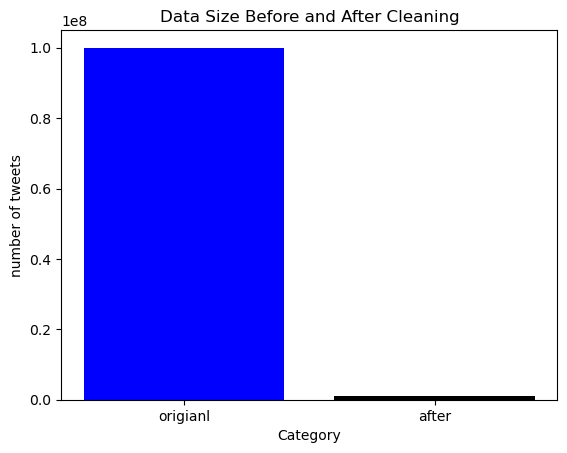

In [56]:
import matplotlib.pyplot as plt
count = [99992797,1052477]
label= ['origianl', 'after']
plt.bar(label,count,color = ['blue', 'black'])
plt.xlabel('Category')
plt.ylabel('number of tweets')
plt.title('Data Size Before and After Cleaning')

In [8]:
df_filter = df_filter.\
withColumn('day', substring('created_at',1,3)).\
withColumn('date', substring('created_at',5,7)).\
withColumn('year', substring('created_at',27,29)).\
withColumn('time', substring('created_at',11,11)).\
withColumn("year", col("year").cast(IntegerType())).\
withColumn("location", df_filter.user['location']).\
withColumn("username", df_filter.user['name']).\
withColumn("userid", df_filter.user['id']).\
withColumn("screen_name", df_filter.user['screen_name']).\
withColumn('country',df_filter.place['country']).\
withColumn('country_code',df_filter.place['country_code'])

In [9]:
df_filter = df_filter.withColumn('timestamp_ms', F.col('timestamp_ms') / 1000.0)
df_filter = df_filter.withColumn('stdate', F.from_unixtime(F.col('timestamp_ms'), 'yyyyMMdd'))

In [10]:
df_filter.limit(1).toPandas()

,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,...,date,year,time,location,username,userid,screen_name,country,country_code,stdate
0,None,Tue May 24 22:09:57 +0000 2022,None,"([], None, [], [], [(1435243987200266241, 1435...",None,None,0,False,low,None,...,May 24,2022,22:09:57 +,"Grand Junction, CO",Claudette Konola,172218797,Konola4Colorado,None,None,20220524


In [11]:
columns = ['userid', 'username','user','date','text', \
           'quoted_status','retweeted_status',\
           'quote_count','retweet_count', 'retweeted', \
           'favorited', 'favorite_count', 'location',\
           'screen_name', 'timestamp_ms', 'stdate','entities','country','country_code']

In [12]:
cleandata = df_filter.select(columns)
cleandata.limit(1).toPandas()

,userid,username,user,date,text,quoted_status,retweeted_status,quote_count,retweet_count,retweeted,favorited,favorite_count,location,screen_name,timestamp_ms,stdate,entities,country,country_code
0,172218797,Claudette Konola,"(False, Thu Jul 29 04:55:18 +0000 2010, False,...",May 24,RT @Gisele23935327: Who did not shoot up a sch...,None,"(None, Tue May 24 22:08:18 +0000 2022, None, (...",0,0,RT,False,0,"Grand Junction, CO",Konola4Colorado,1.653430e+09,20220524,"([], None, [], [], [(1435243987200266241, 1435...",None,None


In [13]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/zhiliny/final_project4'

In [14]:
cleandata.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

22/12/06 17:52:05 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 38 for reason Container marked as failed: container_1670348294163_0001_01_000039 on host: hub-msca-bdp-dphub-students-backup-zhiliny-sw-b5j2.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/06 17:52:05 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 37 for reason Container marked as failed: container_1670348294163_0001_01_000038 on host: hub-msca-bdp-dphub-students-backup-zhiliny-sw-b5j2.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/06 17:52:05 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 38 on hub-msca-bdp-dphub-students-backup-zhiliny-sw-b5j2.c.msca-bdp-students.internal: Container marked as failed: container_1670348294163_0001_01_000039 

In [15]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/zhiliny'

Found 3 items
drwx------   - root root          0 2022-12-06 05:54 gs://msca-bdp-students-bucket/shared_data/zhiliny/final_project1
drwx------   - root root          0 2022-12-06 12:16 gs://msca-bdp-students-bucket/shared_data/zhiliny/final_project2
drwx------   - root root          0 2022-12-06 05:36 gs://msca-bdp-students-bucket/shared_data/zhiliny/finalproject


In [16]:
clean_data = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/zhiliny/final_project2')
# clean_data.count()

In [17]:
clean_data.limit(1).show()

+-------------------+--------+--------------------+-------+--------------------+-------------+----------------+-----------+-------------+---------+---------+--------------+--------+---------------+----------------+--------+--------------------+-------+
|             userid|username|                user|   date|                text|quoted_status|retweeted_status|quote_count|retweet_count|retweeted|favorited|favorite_count|location|    screen_name|    timestamp_ms|  stdate|            entities|country|
+-------------------+--------+--------------------+-------+--------------------+-------------+----------------+-----------+-------------+---------+---------+--------------+--------+---------------+----------------+--------+--------------------+-------+
|1390590130629484551| aaditya|{false, Fri May 0...|Apr 25 |Judge Dismisses L...|         null|            null|          0|            0|         |    false|             0|    null|aaditya89670374|1.650924667189E9|20220425|{[], null, [], [{.